In [81]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection for content losses done by Logistic Regression

# Due to many zero losses especially in content losses, a binary regression was tested to distinguish between occured losses and no losses. 
# The before applied elastic net result showed that the elastic net algorithm might be a bit too complex for the moderate size of training set 
# and the imbalnced distribution with in the response (many zero losses compared to only a very a left skewed distribution of occured content losses)  
# *Sources*
# Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392


import os, sys
import re
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, precision_score, accuracy_score, make_scorer

import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp


## make new base results-folder
hcmc_cantho = "hcmc" # "hcmc", "cantho"
# hcmc_cantho = "hcmc_cantho" # "hcmc", "cantho"
Path(f"../model_results/{hcmc_cantho}/").mkdir(parents=True, exist_ok=True)
# os.chdir(f"../model_results/{hcmc_cantho}/")
print(os.getcwd())


p.main()  # create/update model settings
#s.init()
seed = s.seed

import contextlib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

## settings for cv
kfolds_and_repeats =  7, 2 # 10, 5  # <k-folds, repeats> for nested cv
cv = RepeatedStratifiedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)

# ## make new base results-folder
# hcmc_cantho = "hcmc" # "hcmc", "cantho"
# # hcmc_cantho = "hcmc_cantho" # "hcmc", "cantho"
# Path(f"../../{hcmc_cantho}/").mkdir(parents=True, exist_ok=True)
# os.chdir(f"../../{hcmc_cantho}/")
# print(os.getcwd())

## save models and their evaluation in following folders:
Path(f"../model_results/models_trained/{hcmc_cantho}/chance_of_loss/nested_cv_models").mkdir(parents=True, exist_ok=True)
Path(f"../model_results/models_trained/{hcmc_cantho}/chance_of_loss/final_models").mkdir(parents=True, exist_ok=True)
Path(f"../model_results/models_evaluation/{hcmc_cantho}/chance_of_loss").mkdir(parents=True, exist_ok=True)
Path(f"../model_results/selected_features/{hcmc_cantho}/chance_of_loss").mkdir(parents=True, exist_ok=True)




c:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\feature-selection\Feature_selection


<Figure size 2000x1000 with 0 Axes>

In [82]:
target = "Target_relative_contentloss_euro"
# target = "Target_abs_loss"


## load DS for relative content loss
df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
# df_candidates = pd.read_excel("../../input_survey_data/input_data_cantho_2013_quicktest.xlsx", header=0)
# df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb_cantho.xlsx")
# df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_cantho.xlsx")  # ACC: ~57%, 260cases from which 140 are zero-loss

## move targets to beginning
df_candidates.insert(0, "Target_relative_contentloss_euro", df_candidates.pop("Target_relative_contentloss_euro"))




In [83]:
## features with most missing values
pp.percentage_of_nan(df_candidates)

Percentage of missing values per feature [%]
 shp_registered_capital_euro         8.0
hh_monthly_income_euro              4.0
bage                                4.0
inundation_duration_h               1.0
b_area                              1.0
Target_relative_contentloss_euro    0.0
precautionary_measures_expensive    0.0
shp_employees                       0.0
resilienceLeftAlone                 0.0
resilience                          0.0
emergency_measures                  0.0
precautionary_measures_lowcost      0.0
flood_experience                    0.0
contaminations                      0.0
flowvelocity                        0.0
dtype: float64


## Explore correlations 
Visualize correlations between candidate predictors and targets incl rloss, abs loss, business reduction

In [84]:
# f.plot_correlations(df_candidates)

In [85]:
# # ### Test : remove / set to np.nan the two datapoints in abs loss which are very high
# sns.regplot(x=df.Target_contentloss_euro, y=df.shp_employees,
#     lowess=True, ci=False,
#     line_kws={'color': 'red', 'lw': 1},
#     scatter_kws={'color': 'black', 's': 20}
#     )

# # #sns.boxenplot(df.Target_contentloss_euro)
# # sns.boxenplot(df.Target_relative_contentloss_euro)
# # # sns.boxenplot(df.Target_businessreduction)
# # sns.boxenplot(df.shp_employees)


**Outlier removal**
Remove outleris for certain columns based on percentiles

count    310.000000
mean      11.087742
std       40.926339
min        0.200000
25%        2.000000
50%        3.000000
75%        6.000000
max      600.000000
Name: inundation_duration_h, dtype: float64
Axes(0.125,0.11;0.775x0.77)


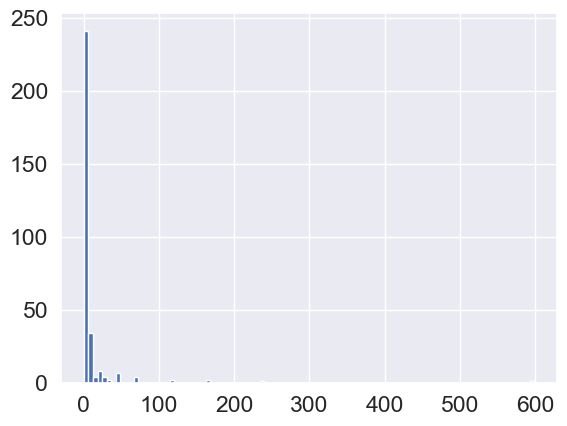

In [86]:
## inundation_duration_h
print(df_candidates.inundation_duration_h.describe())
print(df_candidates.inundation_duration_h.hist(bins=100))


In [87]:

# # # df_candidates = df_candidates.loc[ ~(df_candidates.inundation >= 15000), :]
# # print(df_candidates.shape)
# # df_candidates.hh_monthly_income_euro.describe()

# print(df_candidates.shape)
# print(df_candidates.inundation_duration_h.hist(bins=50))

# #low = .00
# high = .99
# #high = .95
# quant_df = df_candidates.quantile([high])
# # quant_df = df_candidates.quantile([low, high])
# print(max(quant_df.inundation_duration_h))

# # Next filtering values based on computed percentiles. To do that I use an apply by columns and that's it !
# df_candidates = df_candidates.apply(
#     lambda x: #x[(x > quant_df.loc[low, x.name]) & 
#                 (x < quant_df.loc[high,x.name]), axis=0)

In [88]:
# df_candidates = df_candidates.loc[ ~(df_candidates.inundation_duration_h >= 300), :]
# print(df_candidates.shape)
# df_candidates.inundation_duration_h.describe()


In [89]:
# print( len(df_candidates.loc[df_candidates.b_area >= 300, :]))
# df_candidates = df_candidates.loc[~(df_candidates.b_area >= 300), :]
# print(df_candidates.shape)
# df_candidates.b_area.describe()

In [90]:
print(len(df_candidates.loc[ (df_candidates.shp_employees >= 10), :]))  # less tha n10 employess = micro business according to World Bank definiton
df_candidates = df_candidates.loc[ ~(df_candidates.shp_employees >= 10), :]
df_candidates.shp_employees.value_counts()

0


shp_employees
1    155
2    112
3     22
4     16
6      6
5      2
7      1
Name: count, dtype: int64

In [91]:
# df_candidates = df_candidates.loc[ ~(df_candidates.shp_registered_capital_euro >= 5000), :]
print( len(df_candidates.loc[df_candidates.shp_registered_capital_euro >= 20000, :]))
#df_candidates = df_candidates.loc[ ~(df_candidates.shp_registered_capital_euro >= 20000), :]
print(df_candidates.shape)
df_candidates.shp_registered_capital_euro.describe()
# df_candidates.shp_registered_capital_euro.hist(bins=50)

5
(314, 17)


count       289.000000
mean       2627.044637
std        7880.116959
min          36.800000
25%         368.300000
50%         736.500000
75%        1841.300000
max      110476.900000
Name: shp_registered_capital_euro, dtype: float64

In [92]:
print( len(df_candidates.loc[(df_candidates.hh_monthly_income_euro >= 2000), :]))
# df_candidates = df_candidates.loc[ ~(df_candidates.hh_monthly_income_euro >= 2000), :]
print(df_candidates.shape)

df_candidates.hh_monthly_income_euro.describe()


4
(314, 17)


count     301.000000
mean      414.139203
std       345.306255
min       110.500000
25%       294.600000
50%       294.600000
75%       552.400000
max      3314.300000
Name: hh_monthly_income_euro, dtype: float64

In [93]:
print(len(df_candidates.loc[ (df_candidates.shp_avgmonthly_sale_euro >= 2000), :]))
# df_candidates = df_candidates.loc[ ~(df_candidates.shp_avgmonthly_sale_euro >= 2000), :]
print(df_candidates.shape)
df_candidates.shp_avgmonthly_sale_euro.describe()


6
(314, 17)


count     314.000000
mean      348.333121
std       430.462734
min        92.100000
25%        92.100000
50%       276.200000
75%       276.200000
max      2761.900000
Name: shp_avgmonthly_sale_euro, dtype: float64

In [94]:
# plot_correlations(df_candidates)

In [95]:
# ## test rloss <= 0.5 due that for HCMC also this imporved the alogrithm to ACc=60% - no improement for combi df when rloss only < 0.5
# #df_candidates = df_candidates.loc[ ~(df_candidates.Target_relative_contentloss_euro >= 1.0), :]
# print(len(df_candidates.loc[ ~(df_candidates.Target_relative_contentloss_euro >= 0.5), :]))
# df_candidates = df_candidates.loc[ ~(df_candidates.Target_relative_contentloss_euro >= 0.5), :]

print(df_candidates.shape)
df_candidates.Target_relative_contentloss_euro.describe()


(314, 17)


count    314.000000
mean       0.047501
std        0.134701
min        0.000000
25%        0.000000
50%        0.000000
75%        0.026734
max        0.970700
Name: Target_relative_contentloss_euro, dtype: float64

In [96]:
#save to find out which sample are predicted wrongly
df_candidates_continous = df_candidates.copy()
df_candidates_continous.dropna(inplace=True)

## Fit model

In [97]:
# Variables for average classification report
originalclass = []
predictedclass = []

#Make our customer score
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    #return precision_score(y_true, y_pred) # return precision score
    return accuracy_score(y_true, y_pred)

In [98]:
# <!-- **Test final model on CanTHo dataset**
# See if the zero-loss and damage predictions of the final model are reasonable -->

df_cantho = pd.read_excel("../../input_survey_data/input_data_contentloss_cantho.xlsx")
df_cantho.tail(3)
print(df_cantho.shape)
df_cantho = df_cantho.dropna()
# pp.percentage_of_nan(df_cantho)

## cantho only micro-businesses
print("Drop buisness which are not microbusinesses: " ,len(df_cantho.loc[ (df_cantho.shp_employees >= 10), :]))  # less tha n10 employess = micro business according to World Bank definiton
df_cantho = df_cantho.loc[ ~(df_cantho.shp_employees >= 10), :]

print(df_cantho.shape)
X_cantho, y_true_cantho = df_cantho.drop(target, axis=1), df_cantho[target]
y_true_cantho[y_true_cantho > 0] = 1
y_true_cantho = y_true_cantho.astype("Int64")


## add missing features to cantho ds
X_cantho["resilience"] = 0
X_cantho["resilienceLeftAlone"] = 0
X_cantho = X_cantho[df_candidates.drop(target, axis=1).columns.to_list()]
print(X_cantho.columns)

# ## predict on unseen data and evaluate distribution
# y_pred_cantho = final_model.predict(X_cantho)
# pd.concat([y_true_cantho, pd.Series(y_pred_cantho)], axis=1).describe()


(317, 15)
Drop buisness which are not microbusinesses:  6
(279, 15)
Index(['inundation_duration_h', 'water_depth_cm', 'flowvelocity',
       'contaminations', 'flood_experience', 'bage', 'b_area',
       'emergency_measures', 'precautionary_measures_lowcost',
       'precautionary_measures_expensive', 'resilience', 'resilienceLeftAlone',
       'hh_monthly_income_euro', 'shp_employees',
       'shp_registered_capital_euro', 'shp_avgmonthly_sale_euro'],
      dtype='object')


<Axes: >

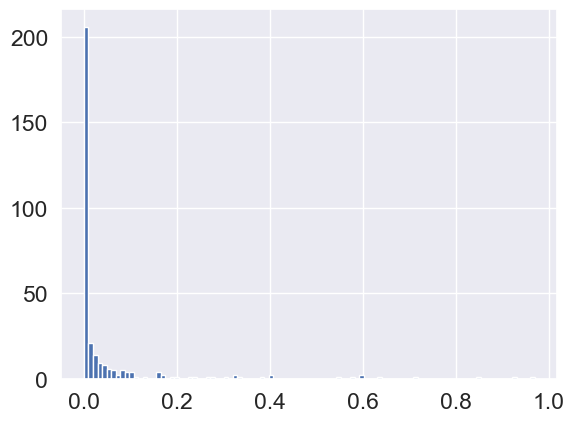

In [99]:
## Test model perofance on hCMC and unseen CanTHo when low-valued damages are set as non damages
df_candidates[target][df_candidates[target]  < 0.01 ] = 0
df_candidates[target].hist(bins=100)

(314, 17)
Index(['Target_relative_contentloss_euro', 'inundation_duration_h',
       'water_depth_cm', 'flowvelocity', 'contaminations', 'flood_experience',
       'bage', 'b_area', 'emergency_measures',
       'precautionary_measures_lowcost', 'precautionary_measures_expensive',
       'resilience', 'resilienceLeftAlone', 'hh_monthly_income_euro',
       'shp_employees', 'shp_registered_capital_euro',
       'shp_avgmonthly_sale_euro'],
      dtype='object')
{'LogisticRegression_hyperparameters': {'model__penalty': ['elasticnet'], 'model__tol': [1e-05, 0.001, 0.01, 0.1, 0.5], 'model__C': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'model__max_iter': [10, 50, 100, 250, 500], 'model__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0], 'model__solver': ['saga'], 'model__random_state': [42]}, 'XGBRegressor_hyperparameters': {'model__n_estimators': [3, 5, 10, 30, 50, 100, 250], 'model__max_depth': [3, 5, 10, 15], 'model__booster': ['gbtree'], 'model__colsample_bytree': [0.33, 0.66, 1.0], 'model__learning_rate': [0.0

classification_report from outer cross validation
              precision    recall  f1-score   support

           0       0.70      0.87      0.77       338
           1       0.55      0.30      0.39       182

    accuracy                           0.67       520
   macro avg       0.62      0.58      0.58       520
weighted avg       0.65      0.67      0.64       520

LogisticRegression:  {'model__tol': 0.01, 'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'elasticnet', 'model__max_iter': 100, 'model__l1_ratio': 0.75, 'model__C': 1}
LogisticRegression:  {'model__tol': 0.5, 'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'elasticnet', 'model__max_iter': 250, 'model__l1_ratio': 0.25, 'model__C': 9}
LogisticRegression:  {'model__tol': 0.001, 'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'elasticnet', 'model__max_iter': 500, 'model__l1_ratio': 1.0, 'model__C': 1}
LogisticRegression:  {'model__tol': 1e-05, 'model__sol

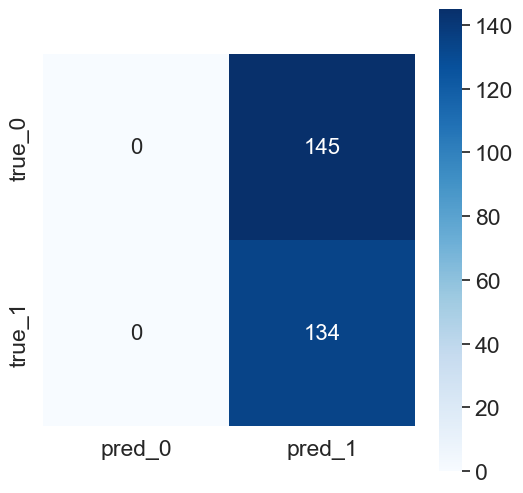

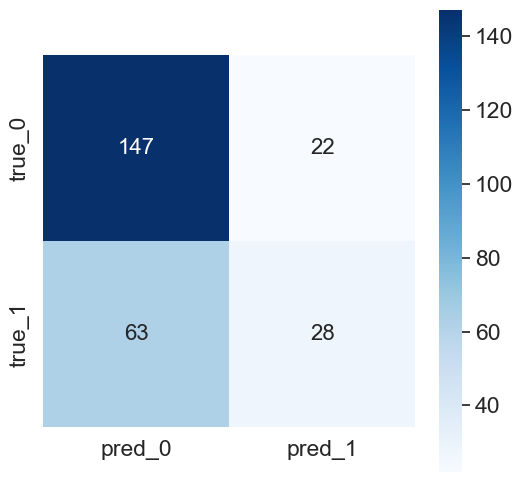

In [100]:
print(df_candidates.shape)


## Fit model

score_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1_macro": "f1_macro", # only for class balanced
    # "f1": "f1",
}
# score_metrics = {"accuracy": make_scorer(classification_report_with_accuracy_score)} 

## test drop flow velocity due to diffenret flooding sources (eg. overwhelmed draingage systems)
# df_candidates = df_candidates.drop("flowvelocity", axis=1)
print(df_candidates.columns)

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 

#pipelines = ["pipe_logreg_bag"]
pipelines = ["pipe_logreg"]
#pipelines = ["pipe_sgd"] # with logreg loss and en penality

eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../utils/hyperparameter_sets.json")
print(hyperparams_set)


for pipe_name in pipelines:

    TIME0 = datetime.now()

    ## load model pipeline and get model name
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')

    try:
        model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # get model name for python models  
    except AttributeError:
        model_name = pipe # get R model name
    

    print( f"\n  ############### Applying {model_name} on {target}:  ###############\n")

    ## load hyperparameter space
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging is used, adapt hyperparameeter names
    if "bag" in pipe_name.split("_"):
        print(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}


    ## load input dataset
    df_Xy = df_candidates
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

    # ## test impact of median imputation on model performance
    # print("test impact of median imputation on model performance")
    # df_Xy[X_names] = df_Xy[X_names].apply(lambda x: x.fillna(x.median()),axis=0)


    ## set target as binary class
    df_Xy[target][df_Xy[target] > 0] = 1
    df_Xy[target] = df_Xy[target].astype("Int64")

    ## clean df from remaining records containg nan
    df_Xy.dropna(inplace=True) ## TODO test with only nan in target removed

    print("Amount of missing target values should be zero: ", df_Xy[target].isna().sum())
    print(
        "Using ",
        df_Xy.shape[0],
        " records, from those are ",
        (df_Xy[target][df_Xy[target] == 0.0]).count(),
        " cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]



    if model_name != "crf":

        ## save evaluation set for later usage in feature importance
        eval_sets[f"{model_name}"] = df_Xy #pd.concat([df_Xy[target], X_crf], axis=1)         
        mf = t.ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score="accuracy", #"roc_auc", #"f1_macro", #"accuracy", # best 54%="precision",#", #"f1_macro", #"precision", #"f1_macro", # accuracy
            cv=cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=seed,
        )
        models_trained_ncv = mf.model_fit_ncv()  # pipe
        
        # from sklearn.utils.class_weight import compute_sample_weight
        # sample_weights_dict = compute_sample_weight(class_weight='balanced', y=df_candidates_continous[target])
        # print(sample_weights_dict)
        s = np.where(df_candidates_continous[target].between(0.000001, 0.1), 0.5, 0.5)  ## NOTE curr best number of y_pred with 72 damage cases (0.6/0.4 weigth=15 damage cases in y_pred )
        # s = np.where(df_candidates_continous[target]==0.0, 0.8, 0.2) 
        # s = np.where(df_candidates_continous[target].between(0.0, 0.001), 0.7, 0.3)  # 0..6 / 0.4 give ca 56 damage cases in ypred NOTE 0.8 / 0.2 44 damage cases in ypred
        # no or only slight sample weight, too high weight such as .8, 0.2 = too less non-damage cases are predicted in NCV
        print(pd.Series(s).describe())
        print(pd.Series(s).value_counts())
           
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            #score_metrics={"precision": make_scorer(classification_report_with_accuracy_score)} ,
            score_metrics=score_metrics,
            cv=cv,
            kfolds=kfolds_and_repeats[0],
            seed=seed,
        )
        model_evaluation_results = me.model_evaluate_ncv(prediction_method="predict_proba")
        #model_evaluation_results = me.model_evaluate_ncv(sample_weights={'model__sample_weight': s}, prediction_method="predict_proba")


        ## Classification report for nested cross validation                
        nested_score = cross_val_score(models_trained_ncv, X=X, y=y, cv=cv, 
               scoring=make_scorer(classification_report_with_accuracy_score))
        # Average values in classification report for all folds in a K-fold Cross-validation  
        # print(nested_score) # scores from each fold
        print("classification_report from outer cross validation") 
        print(classification_report(originalclass, predictedclass)) 


        ## visual check if hyperparameter ranges are good or need to be adapted
        for i in range(len(model_evaluation_results["estimator"])):
            print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


        ## store models evaluation 
        models_scores[model_name] =  {
            k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
        } # get evaluation scores, metric names start with "test_<metricname>"

        
        ## Final model

        ## get final model based on best MAE score during outer cv
        # best_idx = list(models_scores[model_name]["test_f1_macro"]).index(max(models_scores[model_name]["test_f1_macro"]))
        #best_idx = list(models_scores[model_name]["test_precision"]).index(max(models_scores[model_name]["test_precision"]))
        # best_idx = list(models_scores[model_name]["test_recall"]).index(max(models_scores[model_name]["test_recall"]))
        best_idx = list(models_scores[model_name]["test_accuracy"]).index(max(models_scores[model_name]["test_accuracy"]))
        final_model = model_evaluation_results["estimator"][best_idx]
        print("used params for best model:", final_model.best_params_)  # use last model as the best one
        final_model = final_model.best_estimator_

        ## Test performance on CnaTHo Datset
        print("Predict on CanTHo ds")
        y_pred_cantho = final_model.predict(X_cantho)
        print(pd.concat([y_true_cantho, pd.Series(y_pred_cantho)], axis=1).describe())
        print(classification_report( y_true_cantho, y_pred_cantho)) 
        f.plot_confusion_matrix(
            y_true_cantho,
            y_pred_cantho,
            outfile=f"../model_results/models_evaluation/{hcmc_cantho}/chance_of_loss/confusionmatrix_evaluate_on_cantho_{target}.jpg",
        )
        ##                          cantho y_true    cantho y_pred
        # mean                           0.484211    0.898246  no sample weights, no class weights or balancing
        # mean                           0.484211    0.898246  0.6 / 0.4 sample weights on 0.0 - <0.1 losses, no class weights or balancing


        ## predict on entire dataset and save final model
        y_pred = final_model.predict(X) 
        final_models_trained[model_name] = final_model 
        joblib.dump(final_model, f"../model_results/models_trained/can_tho/chance_of_loss/final_models/{model_name}_{target}.joblib")

        ## Feature importance of best model
        importances = me.permutation_feature_importance(final_model, repeats=5)


        ## regression coefficients for linear models
        with contextlib.suppress(Exception):
            models_coef[model_name] = me.calc_regression_coefficients(final_model)
            outfile = f"../model_results/models_evaluation/can_tho/chance_of_loss/regression_coefficients_{model_name}_{target}.xlsx"
            models_coef[model_name].round(3).to_excel(outfile, index=True)
            print("Regression Coefficients:\n", models_coef[model_name].sort_values("probabilities", ascending=False), f"\n.. saved to {outfile}")


    # filename = f'./models_trained_ncv/{model_name}_{target}.sav'
    # pickle.dump(model, open(filename, 'wb'))
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv
    # models_trained[model_name] = model_evaluation_results["estimator"]
    predicted_values[model_name] = me.residuals  # from nested cv

    ## Feature importance
    print("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # mean importnaces across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")

    df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    print("5 most important features:", df_feature_importances.iloc[:5].index.to_list())
    #df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]

    print(
    f"\nTraining and evaluation of {model_name} took {(datetime.now() - TIME0).total_seconds()} seconds\n"
    )


## Print model evaluation based on performance on outer cross-validation 
classifier_model_evaluation = pd.DataFrame(models_scores[model_name]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
classifier_model_evaluation_std = pd.DataFrame(models_scores[model_name]).std(axis=0)   # get respective standard deviations

model_evaluation = pd.concat([classifier_model_evaluation, classifier_model_evaluation_std], axis=1)
model_evaluation.columns = [f"{model_name}_score", f"{model_name}_score_std"]

model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"../model_results/models_evaluation/can_tho/chance_of_loss/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
print("Outer evaluation scores:\n", model_evaluation.round(4), f"\n.. saved to {outfile}")

## Print evaluation nested cv
print("y ture: \n", predicted_values[model_name]["y_true"].value_counts())
print("y pred from nested cv: \n", pd.Series(predicted_values[model_name]["y_pred"]).value_counts())
# ### Empirical median ~ predicted median
for k,v in predicted_values.items():
    print(f"\n{k} estimators from nested cross-validation:")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))

f.plot_confusion_matrix(
    predicted_values[model_name]["y_true"],
    predicted_values[model_name]["y_pred"],
    outfile=f"../model_results/models_evaluation/{hcmc_cantho}/chance_of_loss/confusionmatrix_{target}.jpg",
)


## Print evaluation of final model
print("Classification report from final model:")
print(classification_report( y, y_pred)) 
print("y true: \n", y.value_counts())
print("y pred from final model: \n", pd.Series(y_pred).value_counts())
for k,v in predicted_values.items():
    print(f"\n{k} from final model:")
    print(em.empirical_vs_predicted(y, y_pred))



In [ ]:
## Print model evaluation based on performance on outer cross-validation 
classifier_model_evaluation = pd.DataFrame(models_scores[model_name]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
classifier_model_evaluation_std = pd.DataFrame(models_scores[model_name]).std(axis=0)   # get respective standard deviations

model_evaluation = pd.concat([classifier_model_evaluation, classifier_model_evaluation_std], axis=1)
model_evaluation.columns = [f"{model_name}_score", f"{model_name}_score_std"]

model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"../model_results/models_evaluation/can_tho/chance_of_loss/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
print("Outer evaluation scores (samplewise):\n", model_evaluation.round(3), f"\n.. saved to {outfile}")

        
## Feature Importances 
### drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot[f"{model_name}_importances"] >= 0.0000, : ] 
df_feature_importances_plot = df_feature_importances_plot.sort_values(f"{model_name}_importances", ascending=True)


## TODO update with plt_fi() func as soons a its more flexible in number of models passed to func()
plt.figure(figsize=(30, 22), facecolor="w")
fig = df_feature_importances_plot.plot.barh(
    color="darkblue",
    width=0.5,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")

top_bar = mpatches.Patch(color="darkblue", label=f"{model_name} classification")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
plt.grid(False)
plt.show()

 
fig.get_figure().savefig(f"../model_results/models_evaluation/can_tho/chance_of_loss/feature_importances_{target}.jpg", bbox_inches="tight")
plt.close()


# f.plot_stacked_feature_importances(
#     df_feature_importances_plot["LogisticRegression_importances"],
#     target_name=target,
#     model_names_plot = ("Logistic Regression"),
#     outfile=f"../model_results/models_evaluation/chance_of_loss/feature_importances_{target}.jpg"
# )


### Save final feature space 
## The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_plot[f"{model_name}_importances"].sort_values(ascending=False).index##[:10]
print(final_feature_names)

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../model_results/selected_features/can_tho/chance_of_loss/final_predictors_{target}.xlsx"
)


### Partial dependence
## PDP shows the marginal effect that one or two features have on the predicted outcome.

# ## store partial dependences for each model
# pdp_features = {a : {} for a in [model_name]}

# for model_name in [model_name]:

#     Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
#     X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
#     X_pdp = pd.DataFrame(
#         MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
#         columns=X.columns
#         )
#     Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

#     for predictor_name in X.columns.to_list(): 
#         features_info =  {
#             #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
#             "model" : final_models_trained[model_name], 
        #     "Xy" : Xy_pdp, 
        #     "y_name" : target, 
        #     "feature_name" : predictor_name, 
        #     "scale"  : True
        # }         
        # # get Partial dependences for sklearn models
        # partial_dep = me.get_partial_dependence(**features_info)

        # pdp_features[model_name][predictor_name] = partial_dep


# ## Plot PDP

# most_important_features = df_feature_importances_plot.sort_values(f"{model_name}_importances", ascending=False).index

# categorical = [] # ["flowvelocity", "further_variables .."]
# ncols = 1
# nrows = len(most_important_features[:10])
# idx = 0

# plt.figure(figsize=(5,25))
# # plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


# ## create PDP for all three models
# for feature in most_important_features[:10]:
#     for model_name, color, idx_col in zip([model_name], ["darkblue"], [0]):
        
#         # idx position of subplot
#         ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
    #     feature_info = {"color" : color, "ax" : ax} 

    #     # plot
    #     df_pd_feature = pdp_features[model_name][feature]  
    #     p = f.plot_partial_dependence(
    #         df_pd_feature, 
    #         feature_name=feature, 
    #         partial_dependence_name="yhat", 
    #         categorical=[],
    #         outfile=f"../model_results/models_evaluation/can_tho/chance_of_loss/pdp_{target}.jpg",
    #         **feature_info
    #         )
    #     p

    # idx = idx + 1

# #plt.subplots_adjust(top=0.2)
# plt.savefig(f"../model_results/models_evaluation/can_tho/chance_of_loss/pdp_{target}.jpg", bbox_inches="tight")


# ### Empirical median ~ predicted median
# Compare median and mean of predicted  vs observed target values
for k,v in predicted_values.items():
    print(f"\n{k}")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# HCMC LogReg : with removed 4 highest abs loss removed ACC 0.61
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                       0.61                          0.08
# precision                      0.53                          0.10
# recall                         0.57                          0.15
# f1_macro                       0.59                          0.08 

## Can Tho
## drop in model performance when predict on abs loss (Acc 62%) --> r loss (Acc 0.55 - cv-selfbuilt)
# rloss limit to <= 0.5 - ACC 0.535

## HCMC
# with new cv estimation and rloss <= 0.5  : ACC - 0.60
# LogReg : with removed 4 highest ab loss (old cv apporach) removed ACC 0.61

## HCMC_cantho quick rm
# Outer evaluation scores:
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                       0.52                          0.04
# precision                      0.48                          0.03
# recall                         0.69 **-)                      0.11
# f1_macro                       0.51                          0.06 


f.plot_confusion_matrix(
    predicted_values[model_name]["y_true"],
    predicted_values[model_name]["y_pred"],
    outfile=f"../model_results/models_evaluation/{hcmc_cantho}/chance_of_loss/pdp_{target}.jpg",
)
# no sample weights
# Outer evaluation scores:
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                      0.600                         0.069
# precision                     0.512                         0.120
# recall                        0.370                         0.113
# f1_macro                      0.558                         0.078 


# sample weights
# Outer evaluation scores:
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                      0.600                         0.069
# precision                     0.512                         0.120
# recall                        0.370                         0.113
# f1_macro                      0.558                         0.078 



In [ ]:
## no class balancing
##          1.0       0.42      0.88      0.57       107   # no sample weights
##          1.0       0.42      0.96      0.59       107   # with sample weight 0.7 / 0.3
##          1.0       0.42      0.96      0.59       107   # with sample weight 0.3 / 0.7


## only class balancing (no sample weights)
#"model__class_weight": 0:0.3 , 1:0.7,
#         1.0       0.42      0.96      0.59       107


# #sampel 6 ? 4 with balanced class weighs and less kfolds/repas 
# accuracy                      0.562                         0.079
## --> less good as with stronger sample wieghts , also less good in detailed c.report 
 
# ## sample 8 / 2 (with balanced) + less kfolds/repas 
# accuracy                      0.562                         0.079 no resart # with restart

###################################

# ## sample 8 / 2 (no balancing =None) + less kfolds/repas 
# accuracy                      0.573                         0.066

# ## sample 8 / 2 (no balancing =None) + many kfolds/repas 
## ACC 60%

#          0.0       0.82      0.21      0.33       153
#          1.0       0.45      0.93      0.61       107

#     accuracy                           0.51       260
#    macro avg       0.64      0.57      0.47       260
# weighted avg       0.67      0.51      0.45       260

In [ ]:
model_evaluation_results#["estimator"][0]

# s =df_candidates_continous[target]
# # s = np.where(df_candidates_continous[target] > 0.2, 0.2, df_candidates_continous[target])
# # # s = np.where(df_candidates_continous[target]==0.0, 0.3, df_candidates_continous[target])
# s = np.where(df_candidates_continous[target].between(0.000001, 0.1), 0.7, 0.3)
# # pd.Series(s).describe()

# pd.concat([pd.Series(s), df_candidates_continous[target]], axis=1).tail(30)

In [ ]:
df_candidates_continous["y_pred"] = y_pred
df_candidates_continous.insert(0, "y_pred", df_candidates_continous.pop("y_pred"))
## all False positives from final model
df_falsepositives = df_candidates_continous[(df_candidates_continous.Target_relative_contentloss_euro !=0) & (df_candidates_continous.y_pred==0.0)].sort_values("Target_relative_contentloss_euro").head(50)
df_falsepositives

In [ ]:
print(pd.Series(y).value_counts())
print(pd.Series(y_pred).value_counts())



In [ ]:
# f.plot_correlations(df_candidates)
#         "model__class_weight": [{0:"0.33", 1:"0.67"}],

from sklearn.metrics import classification_report
print(classification_report( y, y_pred)) # baggin: ACC: 0.58
              

In [ ]:
# f.plot_correlations(df_candidates)
#         "model__class_weight": [{0:"0.33", 1:"0.67"}],

from sklearn.metrics import classification_report
print(classification_report( y, y_pred)) # baggin: ACC: 0.58
              

In [ ]:
# models_coef#[f"LogisticRegression_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
# model_coef[f"LogisticRegression_selfbuilt"]

In [ ]:
# models_cv_result.keys()

In [ ]:
## scoring=ACC 5*5 ACC:
# outer CV: ACC: 0.573 (0.087)
# outer CV: precision: 0.491 (0.105)
# outer CV: recall: 0.607 (0.176)
# outer CV: F1: 0.529 (0.114)

## scoring=ACC 10*5 ACC: 

In [ ]:
# ValueError: Classification metrics can't handle a mix of binary and continuous targets
predicted_probabilities
#pd.Series(y_pred).describe()


In [ ]:
#logistic_reg_cv
# ?logistic_reg
# ?KFold
predicted_probabilities

## use continous  probability values for weights in BN
# --> gives chance that a certain vlaue of loss occures 
## model bias over/underestimation of losses


In [ ]:
model_coef["LogisticRegression_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef["LogisticRegression_selfbuilt"].sort_values("features")

In [ ]:
model_coef["logreg_freg"].sort_values("features")

## Evaluation

#### Coefficients of Logistic Regression 

LogReg:  The algorithm estimates the probability of an event occurring by fitting a logistic function to a set of input variables. The coefficients for logistic regression are used to measure the strength of the relationship between the input variables and the output variable.
LogReg doesnt reduce the influence of correlated variables on the model (in contrast to the regularization term in Linear models.)

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
model_coef["logreg_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef["logreg_selfbuilt"].sort_values("features")


In [ ]:
#df_candidates.resistant_material_building_impl.value_counts()

In [ ]:
model_coef["logreg_selfbuilt"].sort_values("features")

In [ ]:
# #models_trained["LogisticRegression"]
# #print(model_coef.keys())
# #model_coef

# import statsmodels.api as sm

# df_candidates_sm = pd.get_dummies(df_candidates_t, columns=[target], drop_first=True)
# y_sm = df_candidates_sm[[target+"_1"]]
# X_sm = df_candidates_sm.drop(target+"_1", axis=1)
# sm_model = sm.Logit(y_sm, sm.add_constant(X_sm)).fit(disp=0)
# print(sm_model.pvalues)
# sm_model.summary()




In [ ]:
# #import statsmodels.api as sm

# print(model_coef.keys())
# print(model_coef["LogisticRegression"].sort_values("coef", key=abs, ascending=False).head(10))

## Interpretation of coefficients:
#  Without normalization: e.g increase of 1 year in AGE means a decrease of <coef_value> of the target in its unit, 
#  On the other hand, categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1 (<-were hot-encoded). 
# Their coefficients are expressed in dollars/hour. Then, we cannot compare the magnitude of different coefficients since the features 
# have different natural scales, and hence value ranges, because of their different unit of measure. 
# [https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]

### Confusion matrix

In [ ]:
## based on neste cv
f.plot_confusion_matrix(
    predicted_values["y_pred"],
    predicted_values["y_pred"],
    show_absolute=True,
    show_normed=True,
    colorbar=False,
    model_name="Logistic_Regression", target_name=target)

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean / variance / std  compared to empirical distribution

In [ ]:
# print("Logistic Reg (binary classification): ", target)
# e.empirical_vs_predicted(
#     X, y.astype(int),
#     models_list=[final_models_trained["LogisticRegression"].named_steps["model"]]    
#     #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
# )

# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


In [ ]:
# #scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# #pd.DataFrame(scores).set_index("test_score").sort_index().T

# # #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
# #pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
# pd.DataFrame(model.cv_results_)[
#         [                                   # only important cv evaluation metrics 
#             "mean_test_score",
#             "mean_fit_time",
#             "rank_test_score",
#             "param_name__estimator__C",
#             "param_name__estimator__penalty",
#             "param_name__estimator__l1_ratio",
#             "param_name__estimator__max_iter"
#         ]
#     ].set_index("rank_test_score").sort_index().T


In [ ]:
## reload models

print(targets)
target = targets[0]

logistic_reg_eval = pickle.load(open(f"./models_trained/logisticreg_{target}.sav", 'rb'))
#elastic_net_eval.get_params()


### Feature importance

In [ ]:
## TODO test to get std of FI _ C:\Users\Anna\Documents\UNI\MA_topic\recycling\sm2t-traffic-speed-model-partial-dependence\SM2T\sm2t-traffic-speed-model_partialDep\traffic_speed_model\modelling.py
#    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)  # based on RF_fi_ 

#plt.rcParams['axes.grid'] = 'none'
#s = df_feature_importances

In [ ]:
### drop features which dont reduce the loss
#df_feature_importances = s
df_feature_importances = df_feature_importances.loc[df_feature_importances.logreg_importances >= 0.0001, : ] 
df_feature_importances = df_feature_importances.sort_values("logreg_importances", ascending=True)

plt.figure(figsize=(30, 22), facecolor="w")
df_feature_importances.plot.barh(
    color="darkblue",
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="logistic regression")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=8)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
#plt.axes().set_facecolor("w")
plt.grid(False)
#plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



###  Partial dependences

In [ ]:
## store partial dependences for each classification algorithm

pdp_features = {a : {} for a in ["LogisticRegression"]}

me = e.ModelEvaluation()


for model_name in ["LogisticRegression"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         

        if model_name != "crf":   
            print(predictor_name)
            partial_dep = me.get_partial_dependence(
                **features_info
            )
        else:  # process R models
            print("crf: ", predictor_name)
            partial_dep = me.decorator_func(       #  change function only temporally        
                # model=final_models_trained[model_name], 
                # Xy=Xy_pdp, 
                # y_name=target, 
                # feature_name=predictor_name, 
                # scale=True
                **features_info
            ) (me.get_partial_dependence)()

        pdp_features[model_name][predictor_name] = partial_dep



In [ ]:
plt.figure(figsize=(10,25))
#plt.subplots_adjust(hspace=0.9)
#plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


most_important_features = df_feature_importances_plot.sort_values("sum_all_importances_weighted", ascending=False).index



idx = 0
categorical = [] # ["flowvelocity"]
ncols = 3
nrows = len(most_important_features[:10])

## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip(["crf", "en", "xgb"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, feature_name=feature, partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"./models_evaluation/chance_of_loss/pdp_{target}.jpg",
            **feature_info
            )
        p

    idx = idx + 3

#plt.subplots_adjust(top=0.2)
#plt.savefig("test_pdp.jpg", bbox_inches="tight")
